In [1]:
!pip install -r ../requirements.txt

In [77]:
import pandas as pd
from data.parliamentApiHelpers import ParliamentAPI
from data.generateJson import get_links
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

In [3]:
coalition = "52"
data_folder = f"../coalition_{coalition}"

In [4]:
df_votes = pd.read_parquet(f"{data_folder}/votes.parquet")
df_voters = pd.read_parquet(f"{data_folder}/voters.parquet")
df_vote_metadata = pd.read_parquet(f"{data_folder}/metadata.parquet")

In [5]:
df_vote_metadata = df_vote_metadata[(df_vote_metadata.date < "2023-03-05")]
df_votes = df_votes.loc[df_vote_metadata.index]
voter_id_to_name = df_voters["name"].to_dict()

In [6]:
adj_matrix = ParliamentAPI.generate_adjacency_matrix(df_votes, "jaccards", ["POOLT", "VASTU", "ERAPOOLETU"])

In [185]:
df_fractions = pd.read_parquet("../fractions.parquet")
df_fractions = df_fractions[df_fractions.shortName.notna()]
e200_id = "e4bf6970-f928-4230-961c-615cc54118f9"
df_fractions.loc[e200_id, "colorHex"] = "#008080"

In [232]:
def merge_components(components, source, target):
    source_c =  set([c for c in components if source in c][0])
    target_c = [c for c in components if target in c][0]
    remaining_component = [c for c in components if c != source_c and c!= target_c]
    new_c = source_c.union(target_c)
    remaining_component.append(new_c)
    return remaining_component, new_c
df_links = get_links(adj_matrix).sort_values(by="value", ascending=False)
all_components = [set([a]) for a in set(df_links.source).intersection(set(df_links.target))]

In [233]:
n = 8
top_n_links = df_links.groupby("source").head(n)
top_n_links = top_n_links[top_n_links["value"] > .4]

In [234]:
# create tree skeleton, ensuring there is a fully connected component
new_links = []
i = 0
df_links_processing = df_links.copy()
while len(all_components) > 1:
    print(i, len(all_components))

    top_link = df_links_processing.iloc[0]
    source = top_link.source
    target = top_link.target
    value = top_link.value
    print(f"{voter_id_to_name[source]}:{voter_id_to_name[target]}:{value}")
    new_links.append(top_link)
    # merge source and value
    all_components, created_component = merge_components(all_components, source, target)
    # filter df_links_processing so that source and target cannot be both in the created component
    cycle_created = (df_links_processing.source.isin(created_component) & df_links_processing.target.isin(created_component))
    df_links_processing = df_links_processing[~cycle_created].sort_values(by="value", ascending=False)

    i+=1
new_links = pd.DataFrame(new_links)
new_links = new_links[new_links["value"] > 0]

0 156
Lauri Läänemets:Hanno Pevkur:1.0
1 155
Urmas Reinsalu:Riina Sikkut:1.0
2 154
Riina Sikkut:Lauri Läänemets:1.0
3 153
Aivar Viidik:Tiiu Aro:1.0
4 152
Aivar Sõerd:Sulev Kannimäe:0.9403409090909091
5 151
Aivar Sõerd:Urve Tiidus:0.9269662921348315
6 150
Aivar Sõerd:Kristen Michal:0.9232954545454546
7 149
Siim Kallas:Aivar Sõerd:0.9171428571428571
8 148
Urve Tiidus:Toomas Jürgenstein:0.9134078212290503
9 147
Urve Tiidus:Andrus Seeme:0.9119318181818182
10 146
Andres Sutt:Urve Tiidus:0.9088319088319088
11 145
Maris Lauri:Urve Tiidus:0.8825214899713467
12 144
Toomas Järveoja:Urve Tiidus:0.8810198300283286
13 143
Signe Kivi:Sulev Kannimäe:0.8685714285714285
14 142
Urve Tiidus:Kristina Šmigun-Vähi:0.8664772727272727
15 141
Siim Kallas:Timo Suslov:0.8604651162790697
16 140
Sulev Kannimäe:Margit Sutrop:0.8567335243553008
17 139
Heiki Hepner:Sulev Kannimäe:0.851123595505618
18 138
Õnne Pillak:Marko Torm:0.8490566037735849
19 137
Andrus Seeme:Priit Sibul:0.8443804034582133
20 136
Sulev Kannimäe

In [235]:
# add top n on top of new_links skeleton
new_links = pd.concat([new_links, top_n_links]).drop_duplicates()

In [236]:
G = nx.from_pandas_edgelist(new_links, source="source", target="target", edge_attr=True)

In [237]:
name_to_color = {df_voters.loc[node]["name"]: df_fractions.loc[df_voters.loc[node]["factionId"]]["colorHex"] for node in G.nodes()}

In [238]:
color = [df_fractions.loc[df_voters.loc[node]["factionId"]]["colorHex"] for node in G.nodes()]

In [239]:
pd.Series({voter_id_to_name[k]:v for k,v in dict(G.degree()).items()}).sort_values(ascending=False)

Sulev Kannimäe      44
Urve Tiidus         43
Aivar Sõerd         41
Kristen Michal      39
Siim Kallas         30
                    ..
Siret Kotka          2
Marko Šorin          2
Annely Akkermann     2
Mailis Reps          1
Martin Repinski      1
Length: 107, dtype: int64

In [274]:
edge_colors = [(0, 0, 0, v**3) for v in new_links.value]

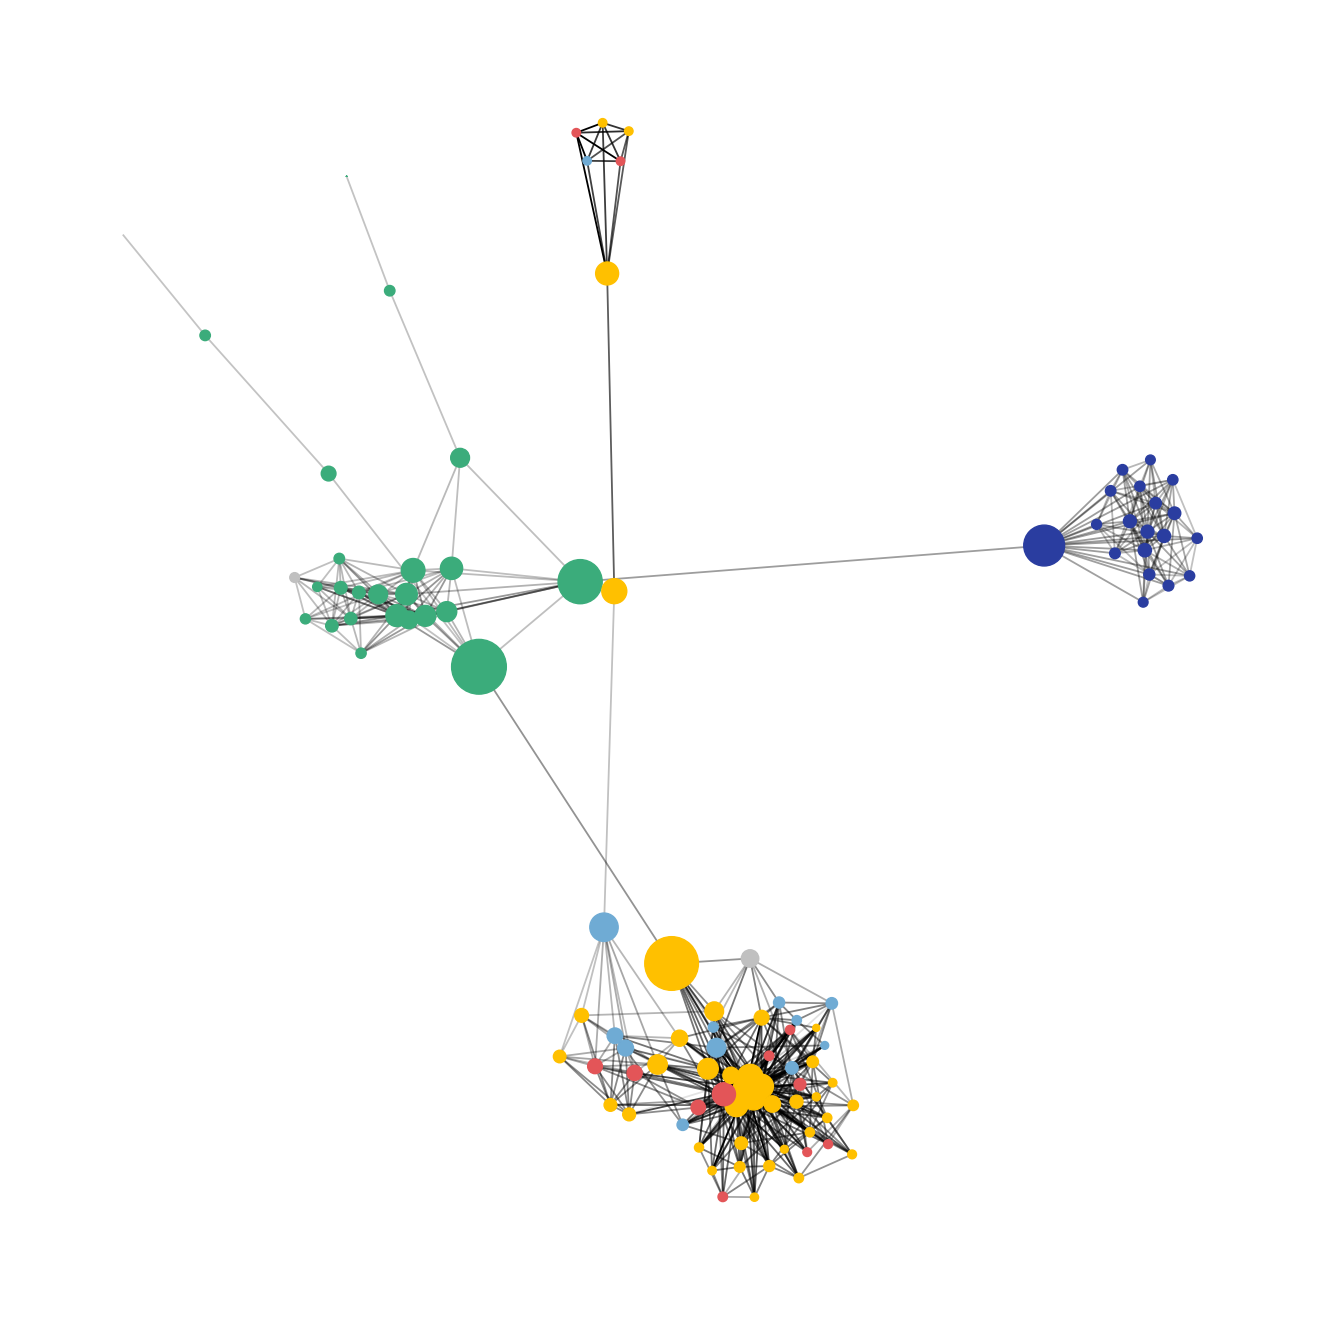

In [275]:
plt.rcParams['figure.figsize'] = [13, 13]
nx.draw(G,
        node_color=color,
        width=1.3,#new_links.value*4,
        edge_color=edge_colors,
        #labels={k:v for k,v in voter_id_to_name.items() if (k in new_links.source.values or k in new_links.target.values)},
        node_size=3000*np.array(list(nx.centrality.current_flow_betweenness_centrality(G).values()))
        )

In [277]:
df_centrality = (pd.Series(dict(nx.centrality.current_flow_betweenness_centrality(G)))
 #.where(lambda x: x>0)
 .dropna()
 .rename("current_flow_betweenness_centrality")
 .rename(index=voter_id_to_name)
 .sort_values(ascending=True))

In [278]:
df_centrality = pd.DataFrame(df_centrality).assign(
    color=df_centrality.index.map(name_to_color)
)

<BarContainer object of 107 artists>

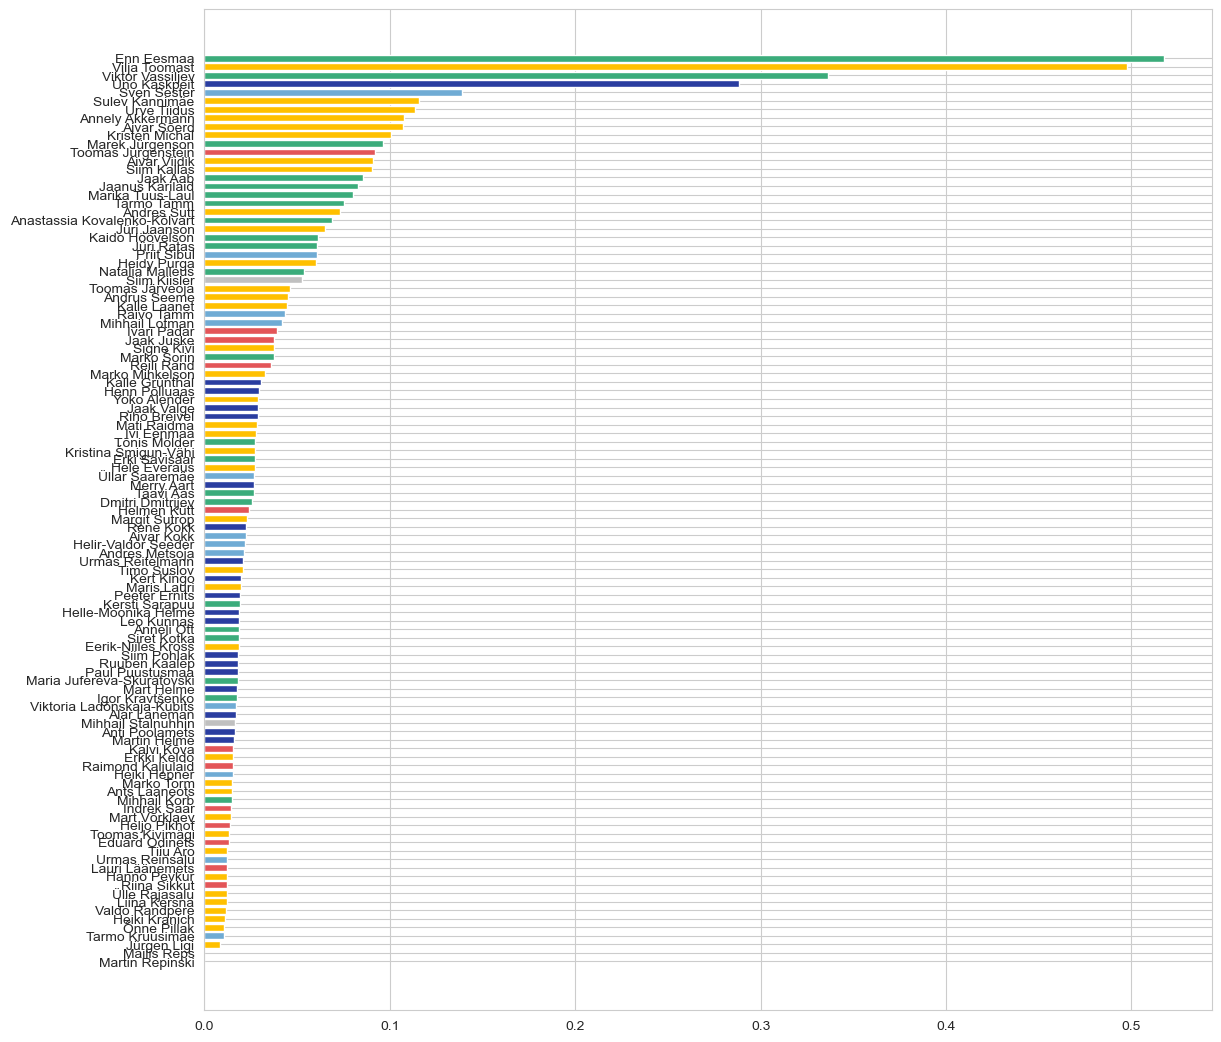

In [279]:
plt.barh(df_centrality.index, df_centrality["current_flow_betweenness_centrality"], color=df_centrality["color"])